In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Google Drive 마운트해서 데이터셋 가져옴

In [ ]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


# ROOT_DIR, DATA_ROOT_DIR 설정

In [ ]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT')  # 압축파일 root dir

# Classification 위한 DATA_ROOT_DIR 설정

In [ ]:
CLASSIFICATION_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Classification')

CLASSIFICATION_TRAIN_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train')

CLASSIFICATION_TEST_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'test')

# Google Drive 에서 dataset download

In [ ]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'Dataset_BUSI_with_GT.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
import os
import shutil

# DATA_ROOT_DIR 삭제
if os.path.exists(DATA_ROOT_DIR):    
    
    shutil.rmtree(DATA_ROOT_DIR)    
    print(DATA_ROOT_DIR + ' is removed !!!')

# CLASSIFICATION_DATA_ROOT_DIR 삭제
if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    
    shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR)    
    print(CLASSIFICATION_DATA_ROOT_DIR + ' is removed !!!')

In [ ]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

In [ ]:
import shutil
import os
import glob

#========================================================
# 전체 파일 확인 (디렉토리와 일부 파일 혼재하고 있음)
# isfile(), isdir() 사용하기 위해서는 full_path를 사용해야 하므로
# os.listdir() 대신에 glob.glob() 사용함
#========================================================

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, '*'))

print(total_file_list)    

#========================================================
# 정답 리스트 추출 (디렉토리 이름이 정답임)
#========================================================

label_name_list = [ file_name.split('/')[-1].strip()  for file_name in total_file_list  if os.path.isdir(file_name) == True ]

print(label_name_list)

['/content/Dataset_BUSI_with_GT/malignant', '/content/Dataset_BUSI_with_GT/normal', '/content/Dataset_BUSI_with_GT/benign']
['malignant', 'normal', 'benign']


#### Classification 데이터 생성

In [ ]:
import os

# CLASSIFICATION_DATA_ROOT_DIR 생성
if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):    # CLASSIFICATION_DATA_ROOT_DIR 생성

    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)
    print(CLASSIFICATION_DATA_ROOT_DIR + ' is created !!')

/content/Classification is created !!


In [ ]:
#========================================================
# copytree 이용해서 정답이름/images 디렉토리를 
# train/정답이름 으로 복사함
#========================================================

for label_name in label_name_list:

    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'/'+label_name)

    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name+' copytree is done !!')

    except Exception as err:
        print(str(err))

malignant copytree is done !!
normal copytree is done !!
benign copytree is done !!


In [ ]:
import os

#========================================================
# Classification 위한 train 정답 및 전체 데이터 개수 확인
# 현재는 image 와 mask 함께 존재하고 있음
#========================================================

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['malignant', 'normal', 'benign']
train label :  malignant  =>  421
train label :  normal  =>  266
train label :  benign  =>  891


In [ ]:
import os
import glob
import pandas as pd

image_file_list = []    # 이미지 파일 리스트
mask_file_list = []     # 마스크 파일 리스트

#===================================================================
# Classification 목적이므로 train 정답 디렉토리에 있는
# mask 파일은 제거하기 위해 Pandas.DataFrame 생성한 후에 
# str.contains 이용해서 이미지와 마스크 파일 목록을 각각 추출함
#===================================================================

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)


for label_name in train_label_name_list:    # 각각의 정답(label)에 대해서

    temp_dic = {}    # 각 정답에 있는 파일목록을 정답과 함께 저장해두기 위한 임시 변수

    file_list = glob.glob(CLASSIFICATION_TRAIN_DATA_ROOT_DIR+'/'+label_name+'/*')

    temp_dic[label_name] = file_list    # temp_dic['label_name'] = [ file_name, ... ]

    # label_name 을 column 으로 가지는 temp DataFrame 생성
    temp_df = pd.DataFrame(temp_dic)

    #############################################################
    # 1개의 column 에 대해서 str.contains 이용해서 image, mask
    # 파일목록을 각각 추출해서 mask 파일은 remove 이용해 삭제함
    #############################################################
    image_file_df = temp_df[~temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

    mask_file_df = temp_df[temp_df[label_name].str.contains('_mask')].reset_index(drop=True)

    print('current label = ', label_name, ' , image nums = ', len(image_file_df), ' , mask nums = ', len(mask_file_df))

    remove_nums = 0
    
    for row in range(len(mask_file_df)):

        try:
            os.remove(mask_file_df.loc[row,label_name])
            remove_nums += 1

        except Exception as err:
            print(str(err))

    print('current label = ', label_name, ' , remove mask nums = ', remove_nums)

['malignant', 'normal', 'benign']
current label =  malignant  , image nums =  210  , mask nums =  211
current label =  malignant  , remove mask nums =  211
current label =  normal  , image nums =  133  , mask nums =  133
current label =  normal  , remove mask nums =  133
current label =  benign  , image nums =  437  , mask nums =  454
current label =  benign  , remove mask nums =  454


# Classification/test 디렉토리 생성
# Classification/test/하위 디렉토리 생성

In [ ]:
#==============================================================
# Classification test dir 생성
#==============================================================
if not os.path.exists(CLASSIFICATION_TEST_DATA_ROOT_DIR):

    os.mkdir(CLASSIFICATION_TEST_DATA_ROOT_DIR)
    print(CLASSIFICATION_TEST_DATA_ROOT_DIR + ' is created !!')
    
else:
    print(CLASSIFICATION_TEST_DATA_ROOT_DIR + ' already exists')
#==============================================================


#==============================================================
# test dir 하위디렉토리에 정답 디렉토리 생성
#==============================================================

for label_name in label_name_list:

    if not os.path.exists(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name)):

        os.mkdir(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name))
        print(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name) + ' is created !!')

    else:
        print(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name) + ' already exists')

/content/Classification/test is created !!
/content/Classification/test/malignant is created !!
/content/Classification/test/normal is created !!
/content/Classification/test/benign is created !!


# move 비율 설정

In [ ]:
# 파일 move 비율

MOVE_RATIO = 0.2  # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

# Classification 각각의 정답별로 원하는 비율만큼 train -> test  move   


In [ ]:
import os
import glob
import shutil
import random

# 파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:

    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)  
    dst_dir_path = os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name)  
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)

    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,len(train_data_file_list)))

    # data shuffle
    random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))

    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0

    for test_data_file in test_data_file_list:

        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))   
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

total [malignant] data file nums => [210]
train data shuffle is done !!!
split nums =>  42
total move nums =>  42
total [normal] data file nums => [133]
train data shuffle is done !!!
split nums =>  26
total move nums =>  26
total [benign] data file nums => [437]
train data shuffle is done !!!
split nums =>  87
total move nums =>  87


# train/* 파일 개수 확인
# test/* 파일 개수 확인

In [ ]:
import os

#==============================================================================
# train 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)

    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================


#==============================================================================
# test 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(CLASSIFICATION_TEST_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name)

    print('test label : ' + label_name + ' => ', len(os.listdir(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================

['malignant', 'normal', 'benign']
train label : malignant =>  168
train label : normal =>  107
train label : benign =>  350
['malignant', 'normal', 'benign']
test label : malignant =>  42
test label : normal =>  26
test label : benign =>  87


# 이미지 shape 설정

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# ImageDataGenerator 이용하여 데이터 불러옴

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) 

validation_data_gen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, batch_size=16,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    subset='training')


validation_generator = validation_data_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, batch_size=16,
                                                               color_mode='rgb', class_mode='sparse',
                                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                               subset='validation')


test_generator = test_datagen.flow_from_directory(CLASSIFICATION_TEST_DATA_ROOT_DIR, batch_size=16,
                                                  color_mode='rgb', class_mode='sparse',
                                                  target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 625 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 155 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'benign': 0, 'malignant': 1, 'normal': 2}
3


# 16 개의 데이터와 정답 출력

In [ ]:
image_data, image_label = train_generator.next()

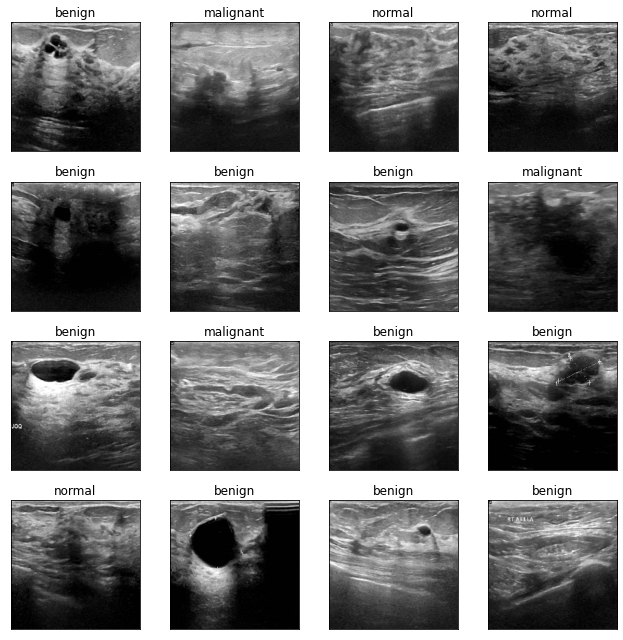

In [ ]:
import matplotlib.pyplot as plt

class_dict = {0:'benign', 1:'malignant', 2:'normal'}

plt.figure(figsize=(9,9))

for i in range(len(image_label)):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[image_label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(image_data[i])

plt.tight_layout()
plt.show()